In [1]:
from matplotlib import pyplot as plt
import platform, os, sys
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    print "Working in Windows..."
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
elif 'Linux' in platform.system():
    print "Working in Linux..."
    sys.path.append(r'/mnt/s/_Data/160603 - EonHe M016v5/modules')
    from BEM import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, resonator_analysis, import_data
from HeliumSurface.static_surface import *

%matplotlib inline
#%config InlineBackend.figure_format='retina'

common.configure_axes(13)

/home/ge/anaconda3/envs/lizards/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Working in Linux...


In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Loading the curvature data from Maxwell

In [3]:
reload(trap_analysis)
t = trap_analysis.TrapSolver(use_FEM_data=True)

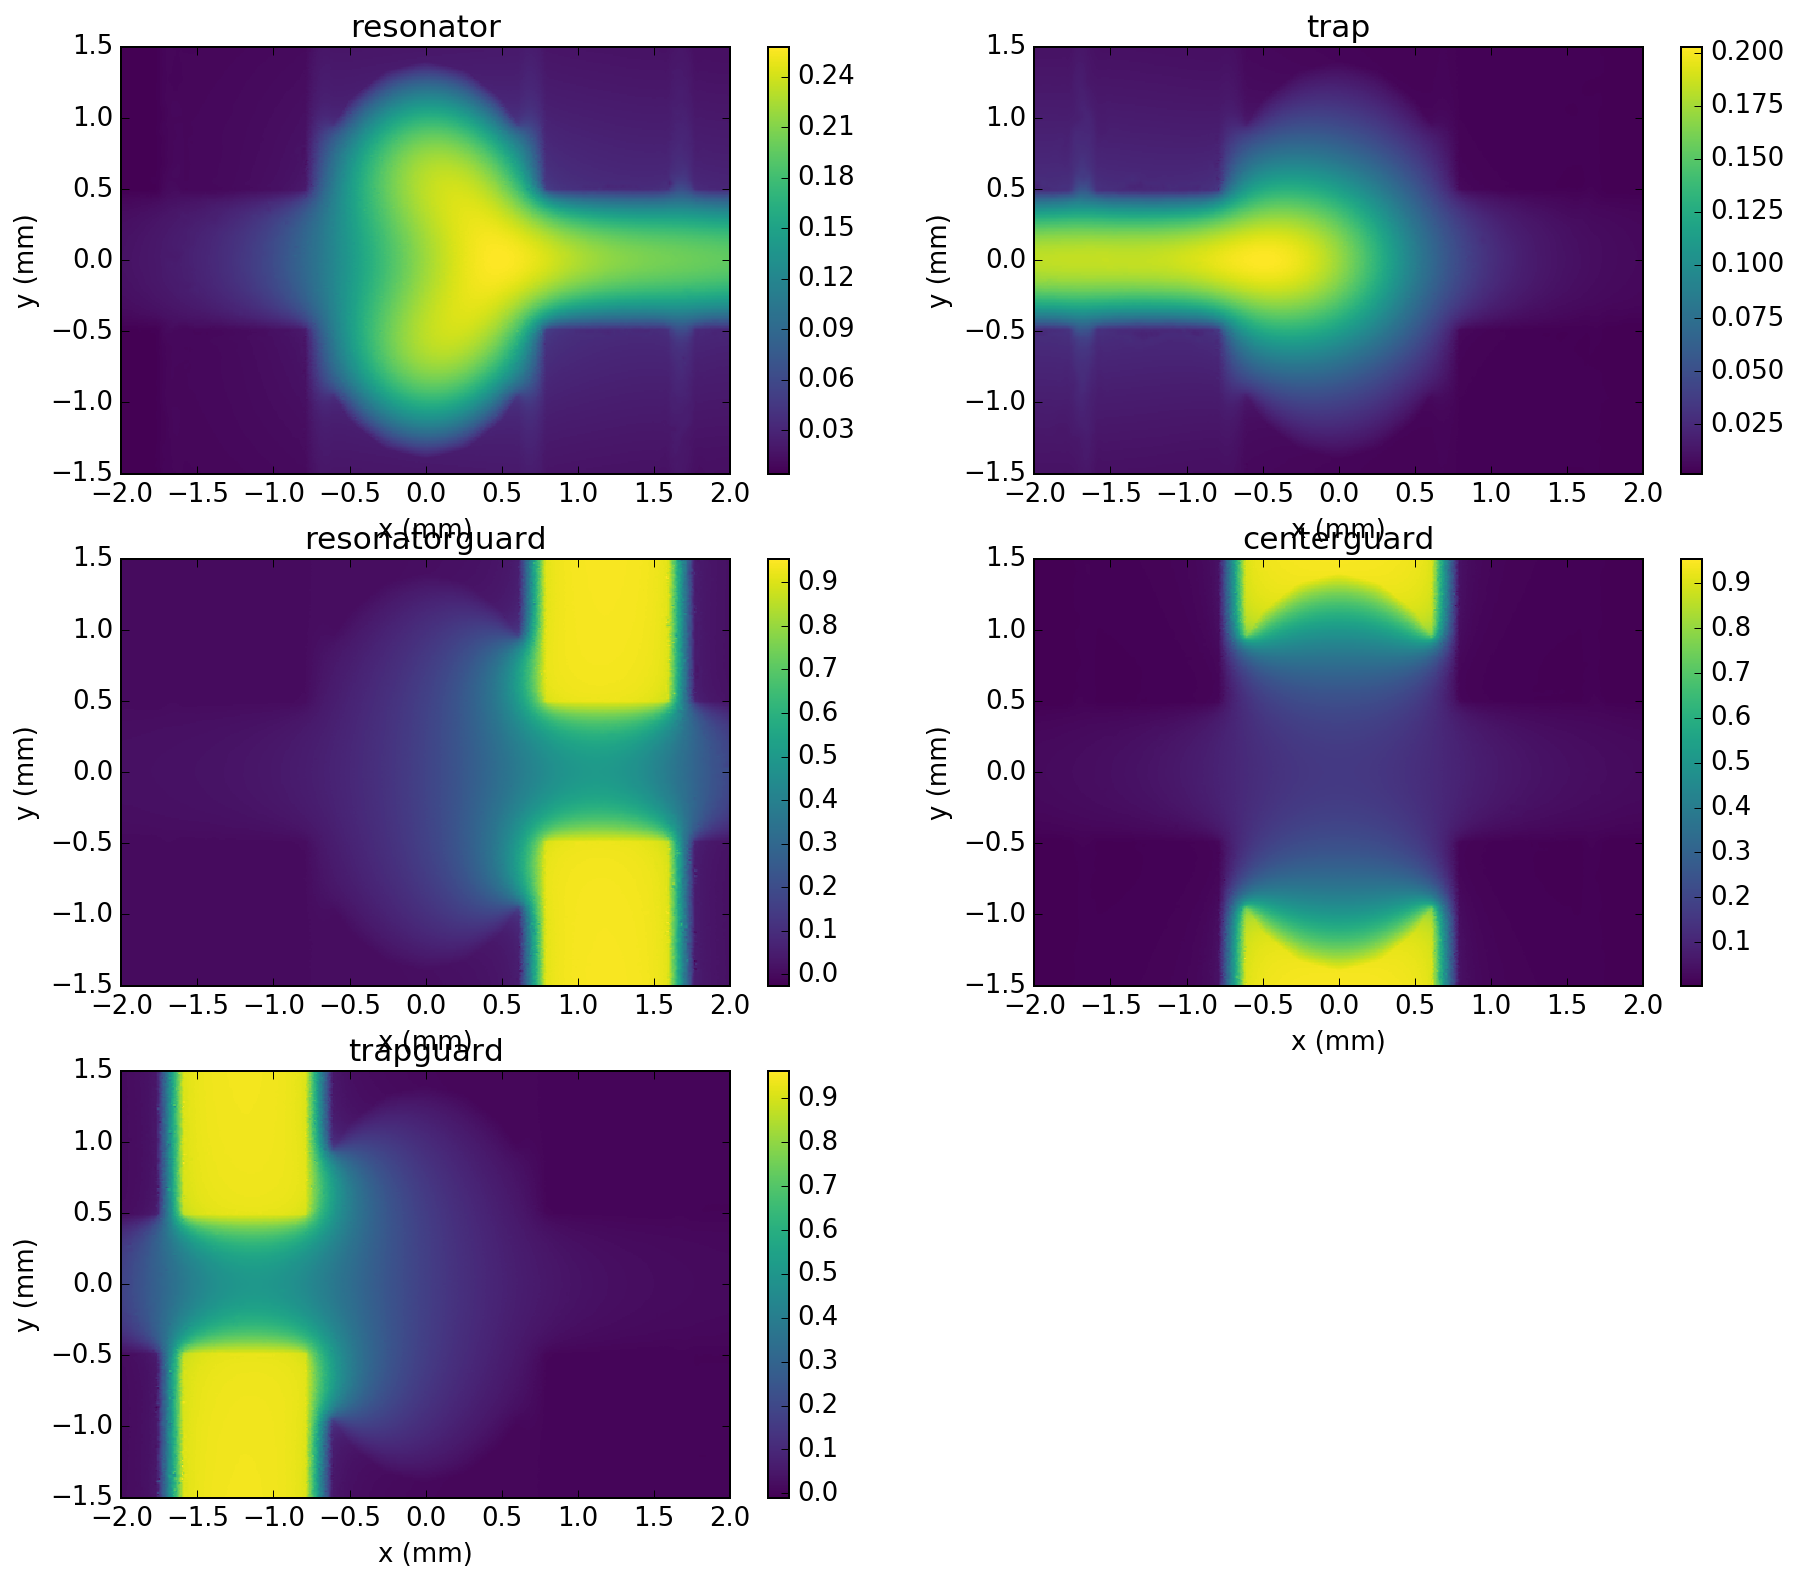

In [5]:
# Evaluate all files in the range
xeval=np.linspace(-2, 2, 501)
yeval = np.linspace(-1.5, 1.5, 301)

datafiles = ["data/simulation/Maxwell/160528 - Trap area - fine mesh/0000 160528 - M016v5 trap xy (resonator) fine mesh.dsp",
             "data/simulation/Maxwell/160528 - Trap area - fine mesh/0001 160528 - M016v5 trap xy (trap) fine mesh.dsp",
             "data/simulation/Maxwell/160528 - Trap area - fine mesh/0002 160528 - M016v5 trap xyz (guardres) fine mesh.dsp",
             "data/simulation/Maxwell/160528 - Trap area - fine mesh/0003 160528 - M016v5 trap xyz (guardcenter) fine mesh.dsp", 
             "data/simulation/Maxwell/160528 - Trap area - fine mesh/0004 160528 - M016v5 trap xyz (guardtrap) fine mesh.dsp"]

plt.figure(figsize=(15.,13.))
output = list()
names = ['resonator', 'trap', 'resonatorguard', 'centerguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    
    plt.subplot(3, 2, len(output)+1)
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = import_data.load_dsp(os.path.join('/mnt/s/_Data/160513 - EonHe M016v5', datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xdata -= xcenter
    ydata -= ycenter
    xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=None, 
                                                         plot_axes='xy', cmap=plt.cm.viridis, plot_mesh=False)
    output.append({'name' : name, 'V' : np.array(Uinterp.T, dtype=np.float64),
                               'x' : np.array(xinterp.T, dtype=np.float64), 'y' : np.array(yinterp.T, dtype=np.float64)})
    plt.title(name)

# An example of coefficients producing $\omega_e/2\pi \simeq $ 16 GHz

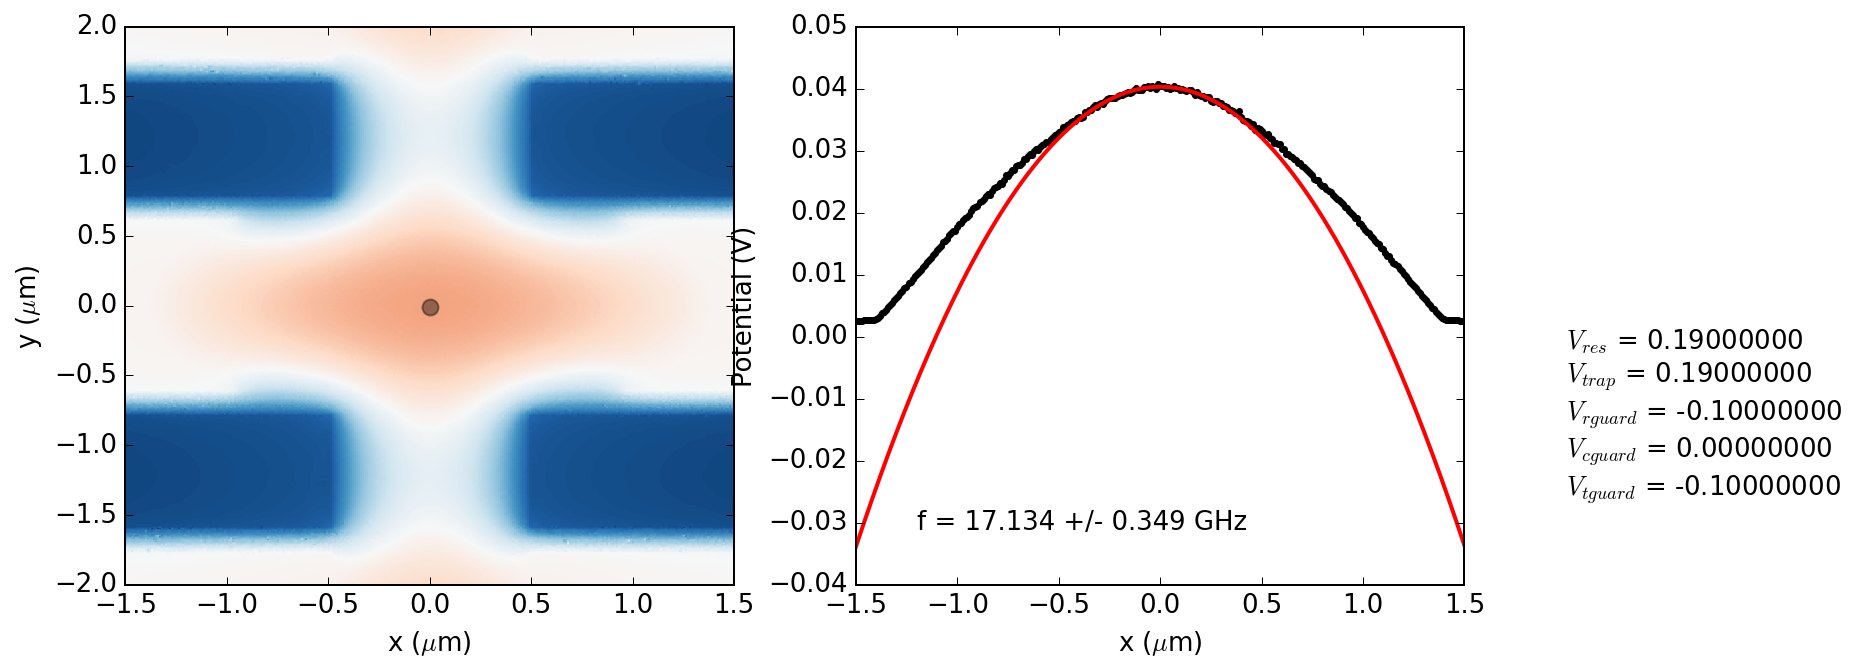

In [6]:
auto_scale = False
scaling = -1.0
fit_potential_minimum = True
color_minimum, color_maximum = (-1.0*10**scaling, +1.0*10**scaling)
resonator = 1.9
trap = 1.9
resonatorguard = -1.0
centerguard = 0.0
trapguard = -1.0

x, y, cropped_potentials = t.crop_potentials(output, xdomain=(np.min(xeval),np.max(xeval)), 
                                             ydomain=(np.min(yeval), np.max(yeval)))
import matplotlib as mpl
common.configure_axes(13)
mpl.rcParams['figure.figsize'] = (12.,5.)

fig = plt.figure()
plt1 = fig.add_subplot(1,2,1)
plt2 = fig.add_subplot(1,2,2)

coefficients = np.array([resonator, trap, resonatorguard, centerguard, trapguard]) * 10**scaling
combined_potential = t.get_combined_potential(cropped_potentials, coefficients)
if not auto_scale:
    plt1.pcolormesh(y, x, combined_potential.T, cmap=plt.cm.RdBu_r, 
                    vmin=color_minimum, vmax=color_maximum)
else:
    plt1.pcolormesh(x, y, combined_potential, cmap=plt.cm.RdBu_r)
if fit_potential_minimum:
    yidx,xidx = np.where(combined_potential==np.max(combined_potential))
else: 
    yidx = np.array([common.find_nearest(y, 0.0)])
    xidx = np.array([common.find_nearest(x, 0.0)])

plt1.plot(x[xidx], y[yidx], 'o', **common.plot_opt("black")) 
plt1.set_xlabel("x ($\mu$m)")
plt1.set_ylabel("y ($\mu$m)")
    
Vdata = combined_potential[:,xidx[0]]
xdata = y
plt2.plot(xdata, Vdata, '.k')
    
try:
    fr, ferr = t.fit_electron_potential(xdata, Vdata, fitdomain=(-0.25, +0.25), do_plot=False)
    plt2.plot(xdata, kfit.parabolafunc(xdata, *fr), '-r', lw=2.0)
    f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
except:
    f0, sigmaf0 = 0, 0
    
plt2.set_xlabel("x ($\mu$m)")
plt2.set_ylabel("Potential (V)")
plt2.set_xlim(min(xdata), max(xdata))
    
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt2.text(xmin + 0.1*(xmax-xmin), ymin + 0.1*(ymax-ymin), "f = %.3f +/- %.3f GHz"%(f0/1E9, sigmaf0/1E9))

biasVoltages = "$V_{res}$ = %.8f\n$V_{trap}$ = %.8f\n$V_{rguard}$ = %.8f\n$V_{cguard}$ = %.8f\n$V_{tguard}$ = %.8f\n" % \
(resonator * 10**scaling, trap * 10**scaling, resonatorguard * 10**scaling, centerguard * 10**scaling, trapguard * 10**scaling)

plt2.text(2, ymin + 0.1*(ymax-ymin), biasVoltages)

# Filtering the 2D curvature data

In [7]:
def curv_xx(x, y, f, smoothing_window_size=10):
    """
    x = np.array([[x0, x1, x2, ...], 
                  [x0, x1, x2, ...], 
                  [x0, x1, x2, ...],
                  ...)
    y = np.array([[y0, y0, y0, ...], 
                  [y1, y1, y1, ...], 
                  [y2, y2, y2, ...], 
                  ...)
    """
    # Determine size of array and differentiate
    nx = np.shape(f)[1]
    ny = np.shape(f)[0]
    new_x = x[2:ny-2,2:nx-2]
    new_y = y[2:ny-2,2:nx-2]
    h = x[0,1] - x[0,0]
    f_x = (f[:,2:nx] - f[:,0:nx-2])/(2*h)
    f_x_smooth = common.moving_average_2d(f_x, window_size=smoothing_window_size)
    # The array has 2 fewer columns 
    nx = np.shape(f_x)[1]
    ny = np.shape(f_x)[0]
    f_xx = (f_x_smooth[:,2:nx] - f_x_smooth[:,0:nx-2])/(2*h)
    f_xx_smooth = common.moving_average_2d(f_xx, window_size=smoothing_window_size)
    # Adjust the number of rows to make it a square matrix again
    return new_x, new_y, f_xx_smooth[2:ny-2,:]

def curv_yy(x, y, f, smoothing_window_size=10):
    """
    x = np.array([[x0, x1, x2, ...], 
                  [x0, x1, x2, ...], 
                  [x0, x1, x2, ...],
                  ...)
    y = np.array([[y0, y0, y0, ...], 
                  [y1, y1, y1, ...], 
                  [y2, y2, y2, ...], 
                  ...)
    """
    # Determine size of array and differentiate
    nx = np.shape(f)[1]
    ny = np.shape(f)[0]
    new_x = x[2:ny-2,2:nx-2]
    new_y = y[2:ny-2,2:nx-2]
    h = y[1,0] - y[0,0]
    f_y = (f[2:ny,:] - f[0:ny-2,:])/(2*h)
    f_y_smooth = common.moving_average_2d(f_y, window_size=smoothing_window_size)
    # The array has 2 fewer rows 
    nx = np.shape(f_y)[1]
    ny = np.shape(f_y)[0]
    f_yy = (f_y_smooth[2:ny,:] - f_y_smooth[0:ny-2,:])/(2*h)
    f_yy_smooth = common.moving_average_2d(f_yy, window_size=smoothing_window_size)
    # Adjust the number of columns to make it a square matrix again
    return new_x, new_y, f_yy_smooth[:,2:nx-2]

def curv_xy(x, y, f, smoothing_window_size=10):
    """
    x = np.array([[x0, x1, x2, ...], 
                  [x0, x1, x2, ...], 
                  [x0, x1, x2, ...],
                  ...)
    y = np.array([[y0, y0, y0, ...], 
                  [y1, y1, y1, ...], 
                  [y2, y2, y2, ...], 
                  ...)
    """
    # Determine size of array and differentiate
    nx = np.shape(f)[1]
    ny = np.shape(f)[0]
    new_x = x[2:ny-2,2:nx-2]
    new_y = y[2:ny-2,2:nx-2]
    dy = y[1,0] - y[0,0]
    dx = x[0,1] - x[0,0]
    f_y = (f[2:ny,:] - f[0:ny-2,:])/(2*dy)
    f_y_smooth = common.moving_average_2d(f_y, window_size=smoothing_window_size)
    # The array has 1 fewer row
    nx = np.shape(f_y)[1]
    ny = np.shape(f_y)[0]
    f_xy = (f_y_smooth[:, 2:nx] - f_y_smooth[:, 0:nx-2])/(2*dx)
    f_xy_smooth = common.moving_average_2d(f_xy, window_size=smoothing_window_size)
    # Adjust the number of columns to make it a square matrix again
    return new_x, new_y, f_xy_smooth[1:ny-1,2:nx-2]

def Ex(x, y, f, smoothing_window_size=10):
    # Determine size of array and differentiate
    nx = np.shape(f)[1]
    ny = np.shape(f)[0]
    new_x = x[2:ny-2,2:nx-2]
    new_y = y[2:ny-2,2:nx-2]
    h = x[0,1] - x[0,0]
    f_x = (f[:,2:nx] - f[:,0:nx-2])/(2*h)
    f_x_smooth = common.moving_average_2d(f_x, window_size=smoothing_window_size)
    ny, nx = np.shape(f_x_smooth)
    # Adjust the number of rows and columns to make it a square matrix again
    return new_x, new_y, f_x_smooth[2:ny-2,1:nx-1]
    
def Ey(x, y, f, smoothing_window_size=10):
    # Determine size of array and differentiate
    ny, nx = np.shape(f)
    new_x = x[2:ny-2,2:nx-2]
    new_y = y[2:ny-2,2:nx-2]
    h = y[1,0] - y[0,0]
    f_y = (f[2:ny,:] - f[0:ny-2,:])/(2*h)
    f_y_smooth = common.moving_average_2d(f_y, window_size=smoothing_window_size)
    ny, nx = np.shape(f_y_smooth)
    # Adjust the number of rows and columns to make it a square matrix again
    return new_x, new_y, f_y_smooth[1:ny-1,2:nx-2]

## 2D filtering with `moving_average_2D`

The moving average window is 14 x 24 samples
The shape of the arrays after calculating the derivatives:
curv_xx: X_plot / Y_plot / F_YY
(497, 297) (497, 297) (497, 297)
curv_yy: X_plot / Y_plot / F_YY
(497, 297) (497, 297) (497, 297)
curv_xy: X_plot / Y_plot / F_XY
(497, 297) (497, 297) (497, 297)


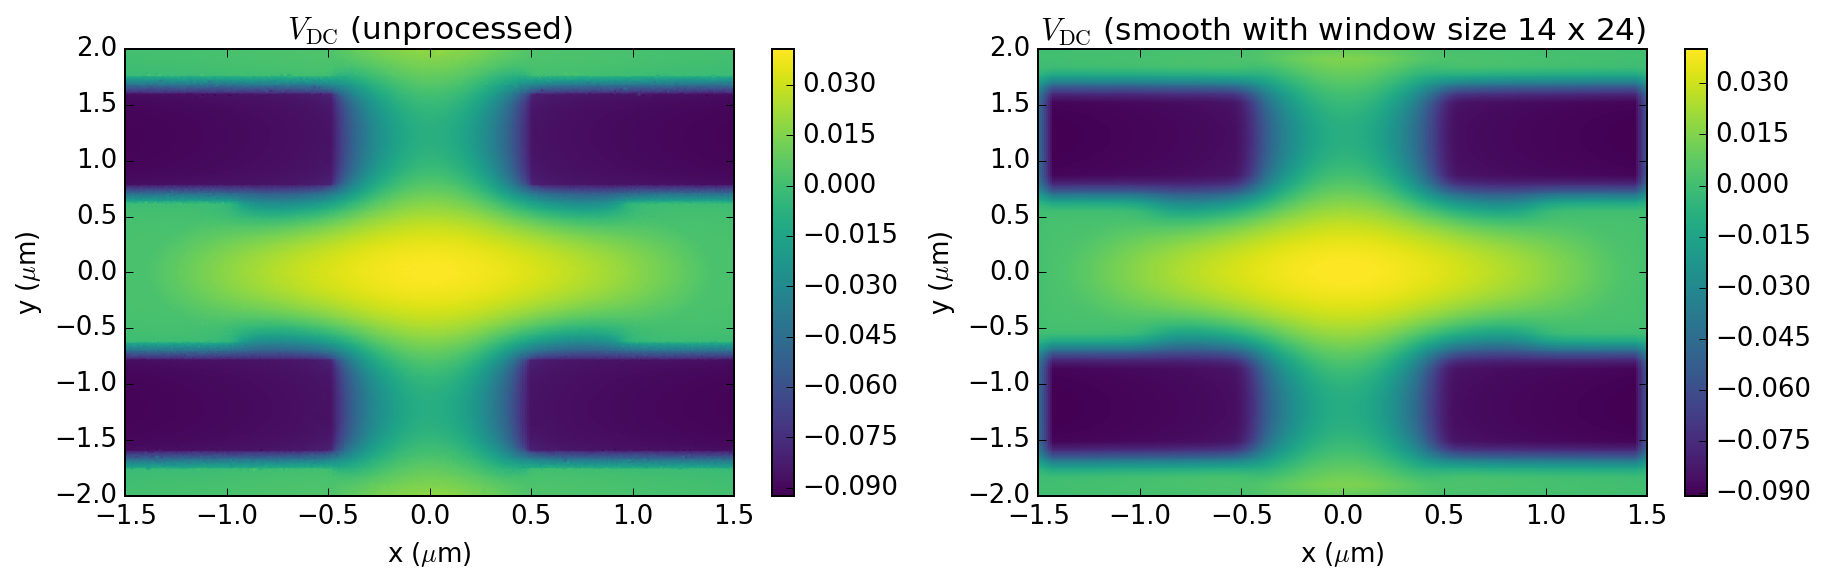

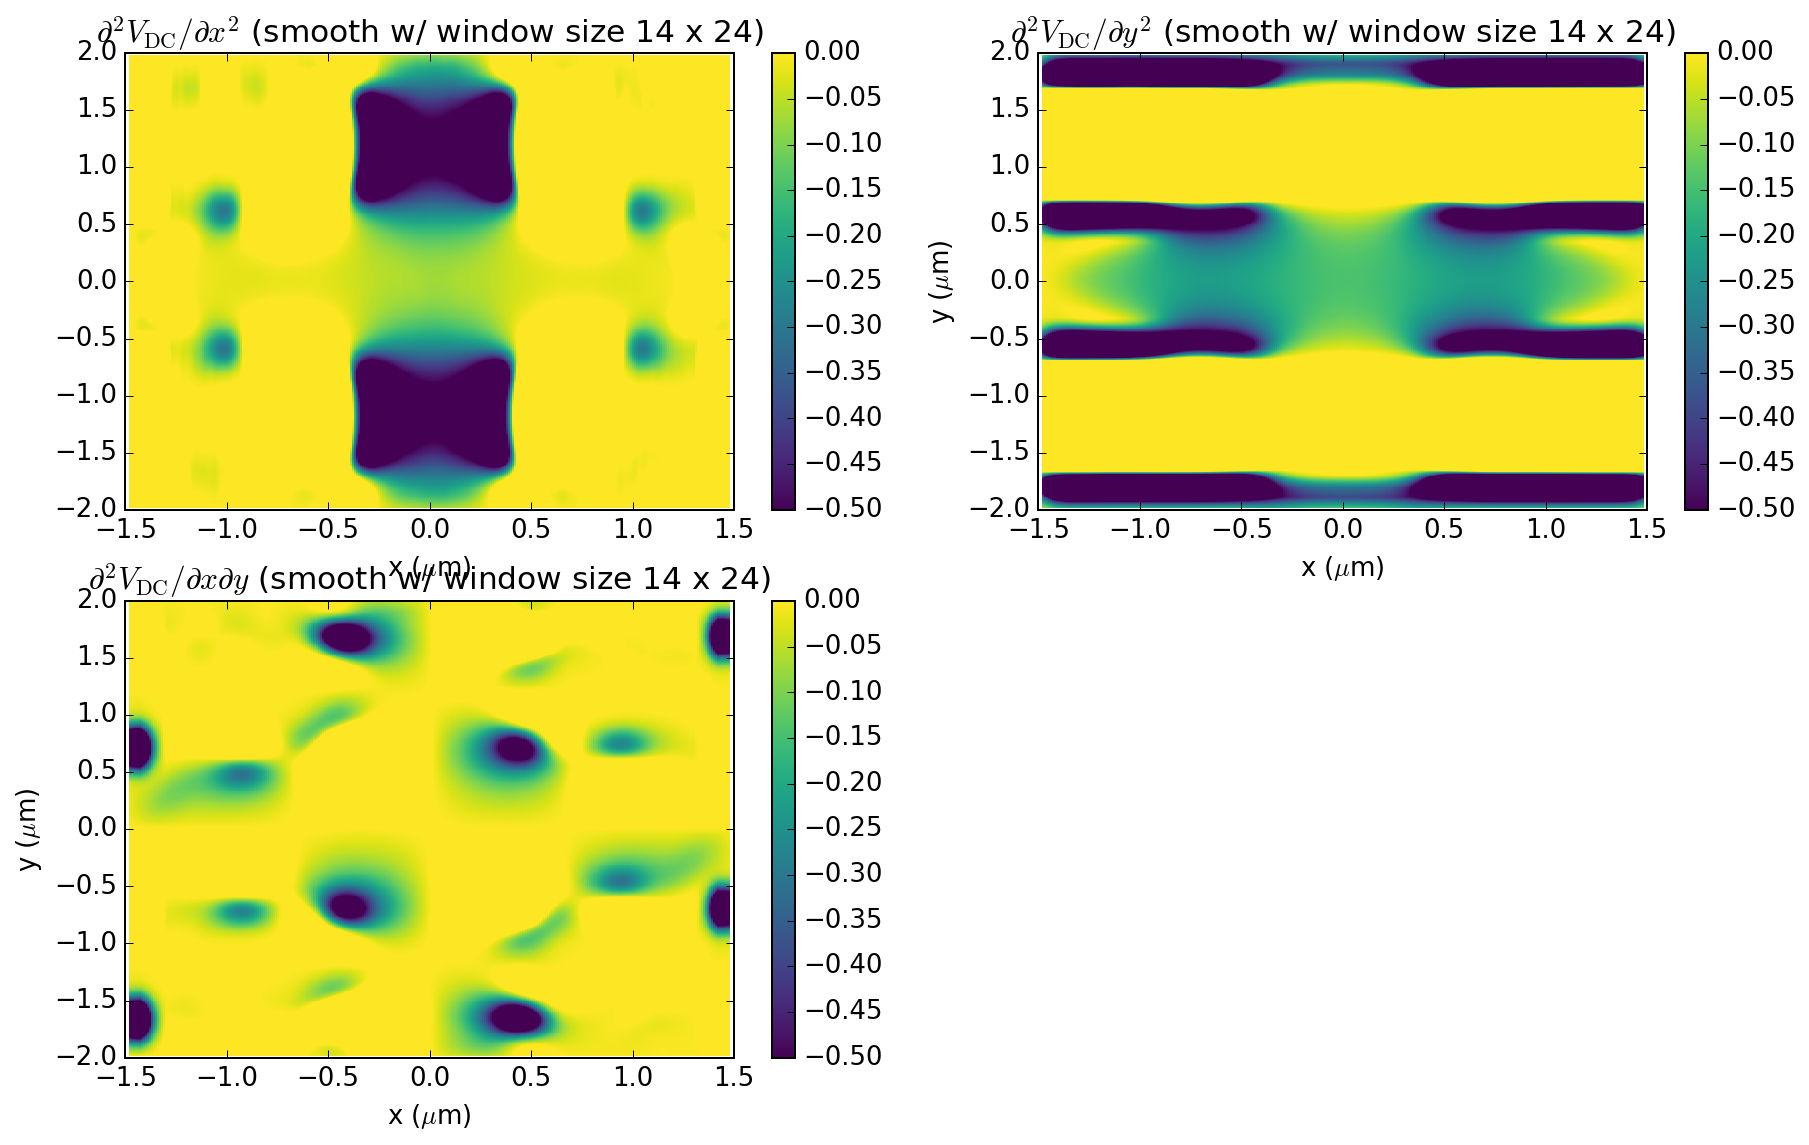

In [30]:
dx = np.diff(x)[0]
dy = np.diff(y)[0]

# The size in the y-direction can be set a little harsher because the potential varies more smoothly in that
# direction. If the number in parentheses is too big, smoothing may lead to loss in detail.
Nx = int(0.20 / dx)
Ny = int(0.15 / dy)

print "The moving average window is %d x %d samples"%(Ny, Nx)

X, Y = np.meshgrid(y, x)

print "The shape of the arrays after calculating the derivatives:"
smooth_combined_potential = common.moving_average_2d(combined_potential.T, (Ny, Nx))
X_plot, Y_plot, F_XX = curv_xx(X, Y, smooth_combined_potential, smoothing_window_size=(Ny, Nx))
print "curv_xx: X_plot / Y_plot / F_YY"
print np.shape(X_plot), np.shape(Y_plot), np.shape(F_XX)

X_plot, Y_plot, F_YY = curv_yy(X, Y, smooth_combined_potential, smoothing_window_size=(Ny, Nx))
print "curv_yy: X_plot / Y_plot / F_YY"
print np.shape(X_plot), np.shape(Y_plot), np.shape(F_YY)

X_plot, Y_plot, F_XY = curv_xy(X, Y, smooth_combined_potential, smoothing_window_size=(Ny, Nx))
print "curv_xy: X_plot / Y_plot / F_XY"
print np.shape(X_plot), np.shape(Y_plot), np.shape(F_XY)

plt.figure(figsize=(15.,4.))
plt.subplot(121)
plt.title("$V_\mathrm{DC}$ (unprocessed)")
plt.pcolormesh(X, Y, combined_potential.T, cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")

plt.subplot(122)
plt.title("$V_\mathrm{DC}$ (smooth with window size %d x %d)"%(Ny, Nx))
plt.pcolormesh(X, Y, common.moving_average_2d(combined_potential.T, window_size=(Ny, Nx)), cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")

plt.figure(figsize=(15.,9.))
plt.subplot(221)
plt.title("$\partial^2 V_\mathrm{DC}/\partial x^2$ (smooth w/ window size %d x %d)"%(Ny, Nx))
plt.pcolormesh(X_plot, Y_plot, F_XX, cmap=plt.cm.viridis, vmin=-0.5, vmax=0)
plt.colorbar()
plt.xlabel("x ($\mu$m)")

plt.subplot(222)
plt.title("$\partial^2 V_\mathrm{DC}/\partial y^2$ (smooth w/ window size %d x %d)"%(Ny, Nx))
plt.pcolormesh(X_plot, Y_plot, F_YY, cmap=plt.cm.viridis, vmin=-0.5, vmax=0)
plt.colorbar()
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")

plt.subplot(223)
plt.title("$\partial^2 V_\mathrm{DC}/\partial x \partial y$ (smooth w/ window size %d x %d)"%(Ny, Nx))
plt.pcolormesh(X_plot, Y_plot, F_XY, cmap=plt.cm.viridis, vmin=-0.5, vmax=0)
plt.colorbar()
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")

## How does filtering influence the numerical 2nd derivative?

Fit function: y = a0 + a1*x**2 + a2*x**4 + ...
===========  ================  =================
Parameter         Value               Std
===========  ================  =================
a0           0.0403292924172   4.02558929246e-05
a1           -0.0360093010483  0.00214406316265
===========  ================  =================
Minimum curvature is -6.76e-02 V/um**2. Compare to fit value: -7.20e-02 V/um**2.


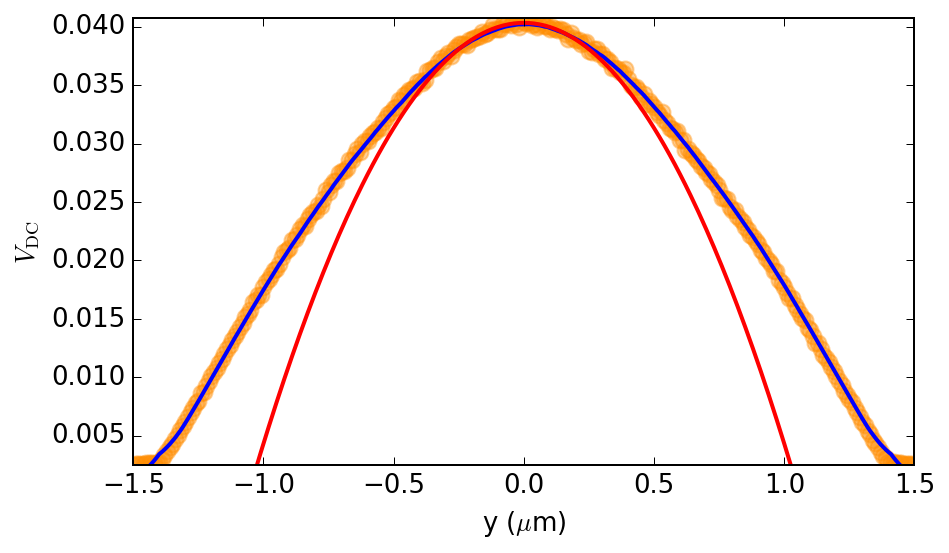

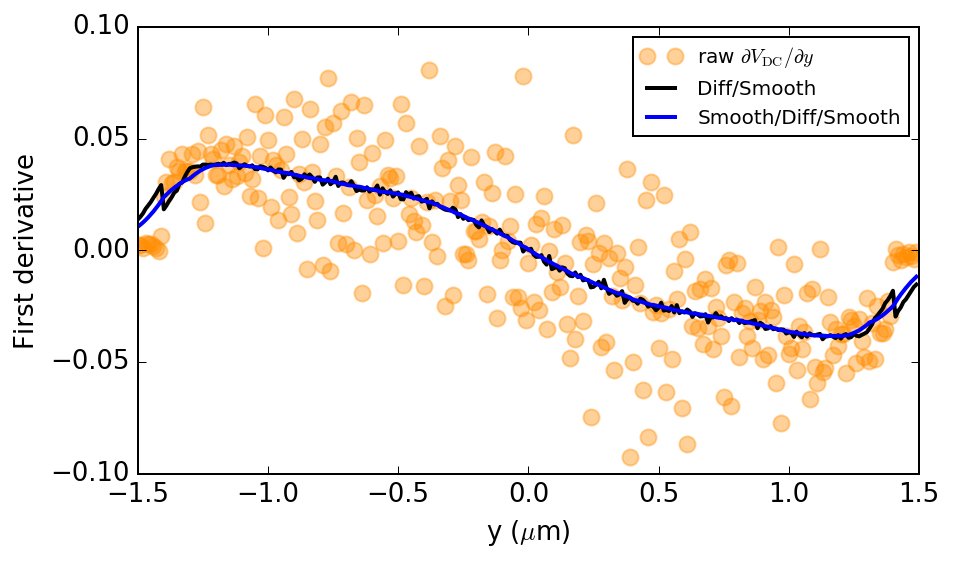

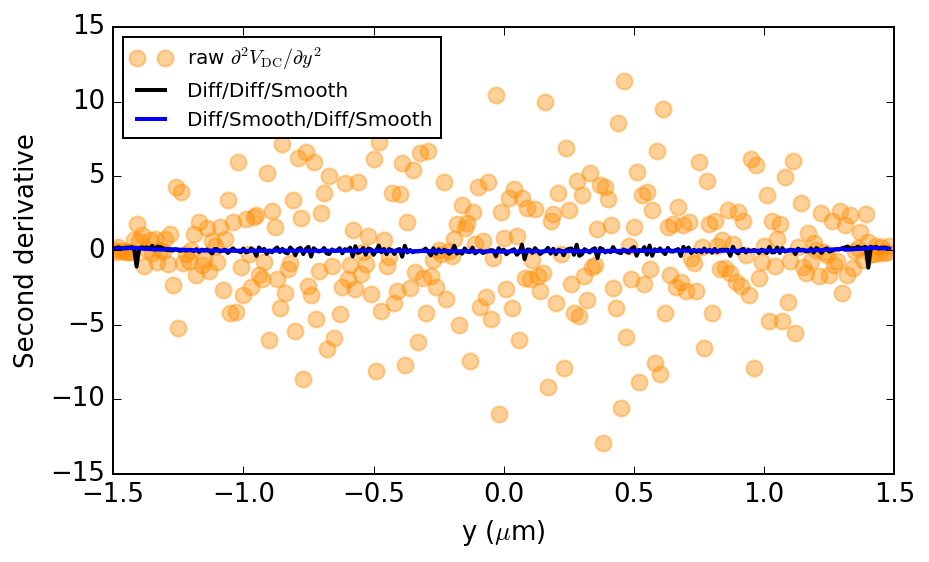

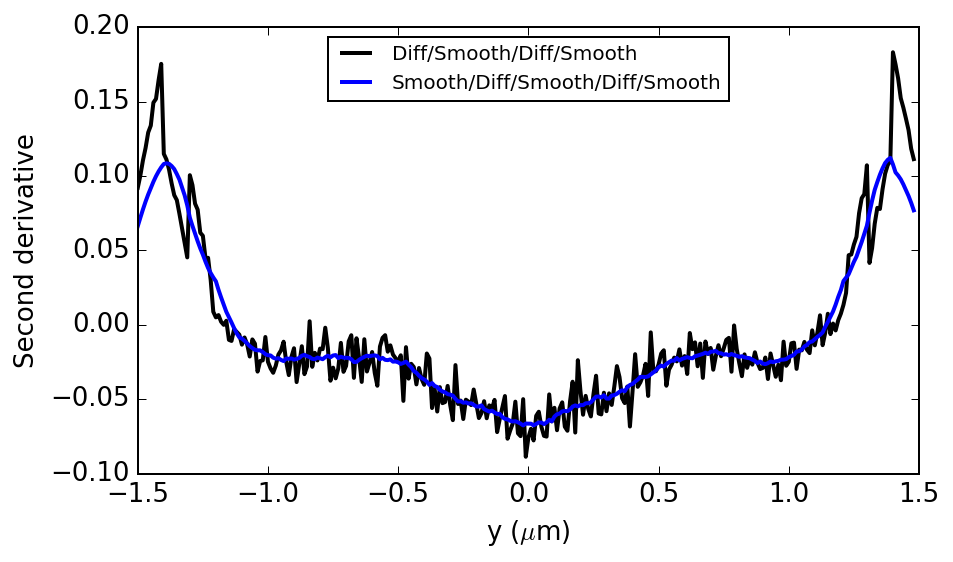

In [31]:
# We'll take a cut along the x-axis now, at y = 0
cut = common.find_nearest(Y[:,0], 0)
window_size = 20
ydata = combined_potential.T[cut, :]
xdata = X[cut, :]

smooth_potential = common.moving_average(ydata, window_size=window_size)
dx = np.diff(xdata)[0]

plt.figure(figsize=(7.,4.))
plt.plot(xdata, ydata, 'o', **common.plot_opt('darkorange'))
plt.plot(xdata, smooth_potential, color='b', lw=2.0)

fr, ferr = kfit.fit_poly(xdata, ydata, mode='even', fitparams=[0, 2], domain=(-0.20, +0.20))
plt.plot(xdata, kfit.polyfunc_even(xdata, *fr), '-r', lw=2.0)
plt.ylim(np.min(ydata), np.max(ydata))
plt.xlabel("y ($\mu$m)")
plt.ylabel("$V_\mathrm{DC}$")
ax = plt.gca()
ax.set_axis_bgcolor('none')


smooth_diff_potential = common.moving_average(common.np.diff(smooth_potential, n=1)/dx, window_size=window_size)

plt.figure(figsize=(7.,4.))
plt.plot(xdata[:-1], np.diff(ydata, n=1)/dx, 'o', 
         label="raw $\partial V_\mathrm{DC}/\partial y$", 
         **common.plot_opt('darkorange'))
plt.plot(xdata[:-1], np.diff(smooth_potential, n=1)/dx, 
         label="Diff/Smooth", 
         color='k', lw=2.0)
plt.plot(xdata[:-1], smooth_diff_potential, 
         label="Smooth/Diff/Smooth", 
         color='b', lw=2.0)
plt.legend(loc=0, prop={'size' : 10})
plt.xlabel("y ($\mu$m)")
plt.ylabel("First derivative")
ax = plt.gca()
ax.set_axis_bgcolor('none')

plt.figure(figsize=(7.,4.))
plt.plot(xdata[:-2], np.diff(ydata, n=2)/dx**2, 'o', 
         label="raw $\partial^2 V_\mathrm{DC}/\partial y^2$", 
         **common.plot_opt('darkorange'))
plt.plot(xdata[:-2], np.diff(smooth_potential, n=2)/dx**2, 
         label="Diff/Diff/Smooth", 
         color='k', lw=2.0)
plt.plot(xdata[:-2], np.diff(smooth_diff_potential, n=1)/dx, 
         label="Diff/Smooth/Diff/Smooth", 
         color='b', lw=2.0)
plt.legend(loc=0, prop={'size' : 10})
plt.xlabel("y ($\mu$m)")
plt.ylabel("Second derivative")
ax = plt.gca()
ax.set_axis_bgcolor('none')


smooth_diff_diff_potential = common.moving_average(np.diff(smooth_diff_potential, n=1)/dx, window_size=window_size)

plt.figure(figsize=(7.,4.))
plt.plot(xdata[:-2], np.diff(smooth_diff_potential, n=1)/dx, 
         label="Diff/Smooth/Diff/Smooth", 
         color='k', lw=2.0)
plt.plot(xdata[:-2], smooth_diff_diff_potential, 
         label="Smooth/Diff/Smooth/Diff/Smooth", 
         color='b', lw=2.0)
plt.legend(loc=0, prop={'size' : 10})
plt.xlabel("y ($\mu$m)")
plt.ylabel("Second derivative")
ax = plt.gca()
ax.set_axis_bgcolor('none')


print "Minimum curvature is %.2e V/um**2. Compare to fit value: %.2e V/um**2." % \
(np.min(smooth_diff_diff_potential), 2*fr[1])

## Quantifying curvatures at different $y$-slices

========  =========================================  ====================  =================
 y (um)    Curvature from computing the derivative    Curvature from fit    Discrepancy (%)
========  =========================================  ====================  =================
-1.0000                    -0.5306                         -0.5456              -2.7531
-0.2500                    -0.1008                         -0.0883              14.1517
 0.0000                    -0.0721                         -0.0670              7.6858
 0.2500                    -0.0941                         -0.0874              7.6855
 1.0000                    -0.5239                         -0.5277              -0.7100
========  =========================================  ====================  =================


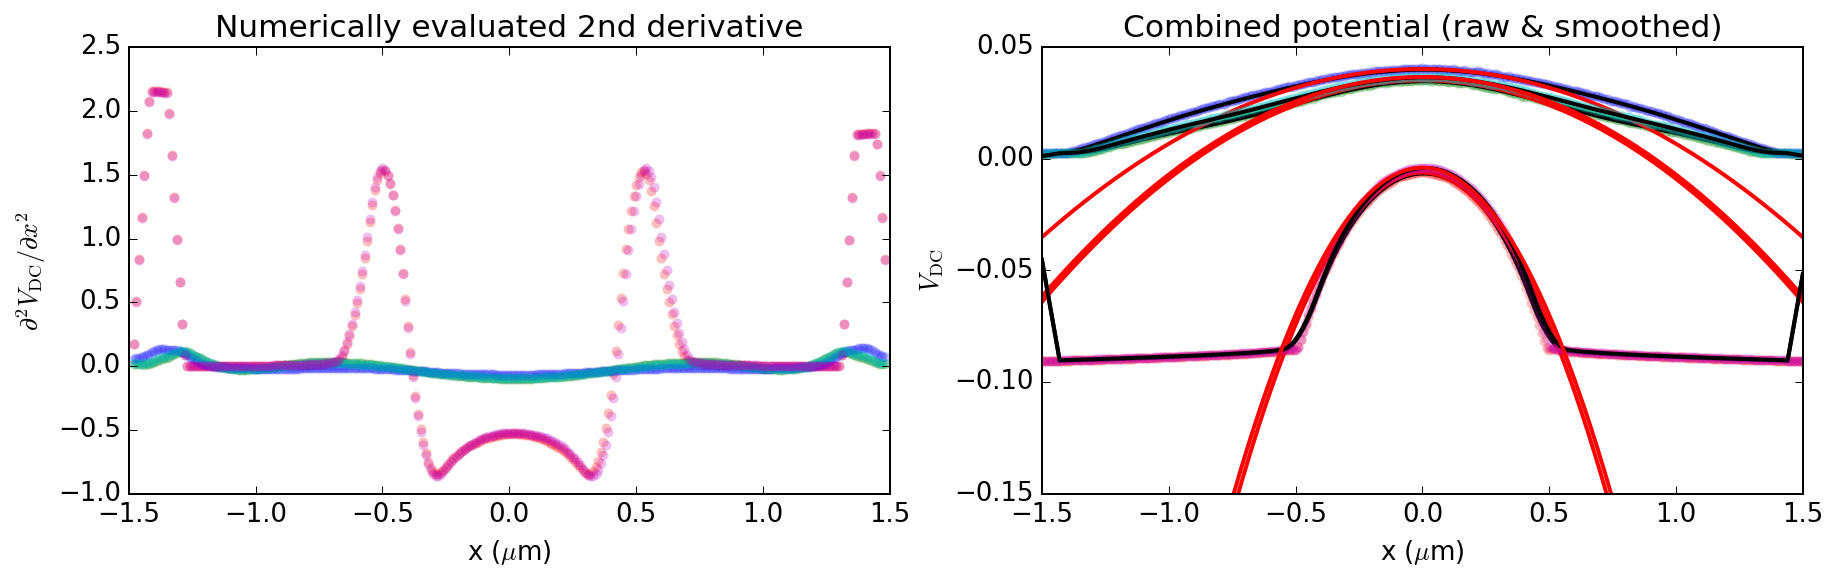

In [32]:
yslices = [-1.0, -0.25, 0.0, 0.25, 1.0]
colors = ['r', 'g', 'b', 'c', 'm']
plt.figure(figsize=(15.,4.))
plt.subplot(121)
plt.xlabel("x ($\mu$m)")
plt.ylabel("$\partial^2 V_\mathrm{DC}/\partial x^2$")
plt.title("Numerically evaluated 2nd derivative")
ax = plt.gca()
ax.set_axis_bgcolor('none')

center_curv_xx = list()
for k, ys in enumerate(yslices): 
    idx = common.find_nearest(Y_plot[:,0], ys)
    plt.plot(X_plot[idx,:], F_XX[idx,:], 'o', color=colors[k], ms=5, mec='none', alpha=0.25)
    center_curv_xx.append(F_XX[idx, common.find_nearest(X_plot[idx, :], 0)])
    
fit_curv_xx = list()
plt.subplot(122)
plt.xlabel("x ($\mu$m)")
plt.ylabel("$V_\mathrm{DC}$")
plt.title("Combined potential (raw & smoothed)")
plt.ylim(-0.15, 0.05)

for k, ys in enumerate(yslices): 
    idx = common.find_nearest(Y_plot[:,0], ys)
    plt.plot(X[idx,:], combined_potential.T[idx,:], 'o', color=colors[k], ms=5, mec='none', alpha=0.25)
    plt.plot(X[idx,:], smooth_combined_potential[idx,:], color='k', lw=2.0)
    
    fr, ferr = kfit.fit_poly(X[idx,:], combined_potential.T[idx,:], mode='even', 
                             fitparams=[0, 2], domain=(-0.20, +0.20), verbose=False)
    plt.plot(X[idx,:], kfit.polyfunc_even(X[idx,:], *fr), '-r', lw=2.0)
    fit_curv_xx.append(2*fr[1])

error = (np.array(center_curv_xx) - np.array(fit_curv_xx)) / np.array(fit_curv_xx) * 100.
ax = plt.gca()
ax.set_axis_bgcolor('none')


print tabulate(zip(yslices, center_curv_xx, fit_curv_xx, error), 
               headers=["y (um)", "Curvature from computing the derivative", "Curvature from fit", "Discrepancy (%)"], 
               tablefmt="rst", floatfmt=".4f", numalign="center", stralign='center')
    
    

# Loading the 2D RF potential data from Maxwell

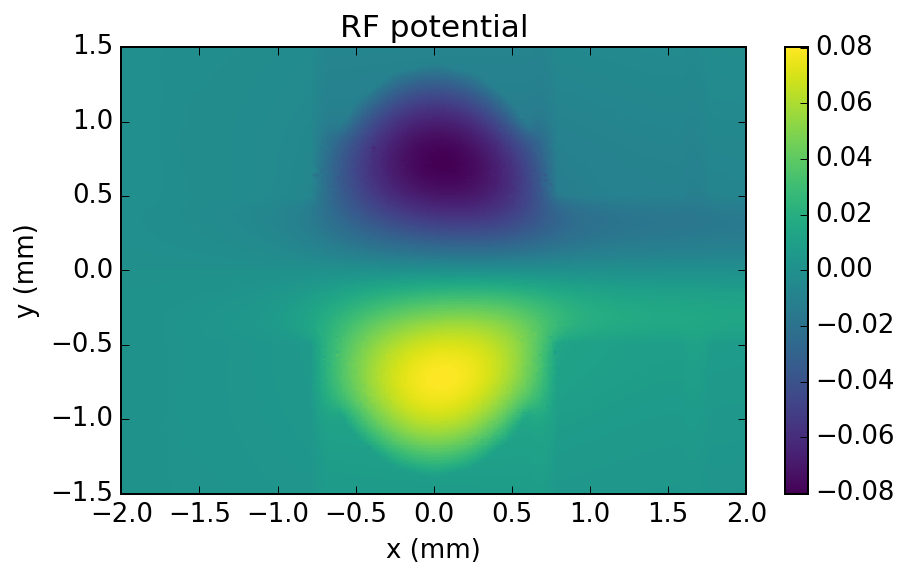

In [35]:
# Evaluate all files in the range
xeval = np.linspace(-2, 2, 501)
yeval = np.linspace(-1.5, 1.5, 301)
datafile = "data/simulation/Maxwell/160528 - Trap area - fine mesh/0005 160610 - M016v5 xy differential mode for Ex.dsp"

plt.figure(figsize=(7.,4.))
common.configure_axes(13)
    
elements, nodes, elem_solution, bounding_box = import_data.load_dsp(os.path.join('/mnt/s/_Data/160513 - EonHe M016v5', datafile))
xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
xcenter = np.mean(bounding_box[0:2])
ycenter = np.mean(bounding_box[2:4])
xdata -= xcenter
ydata -= ycenter
xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=None, 
                                                     plot_axes='xy', cmap=plt.cm.viridis, plot_mesh=False)
plt.title("RF potential")

The moving average window is 14 x 31 samples
The shape of the arrays after calculating the derivatives:
Ex: X_plot / Y_plot / Ex
(497, 297) (497, 297) (497, 297)
Ey: X_plot / Y_plot / Ey
(497, 297) (497, 297) (497, 297)


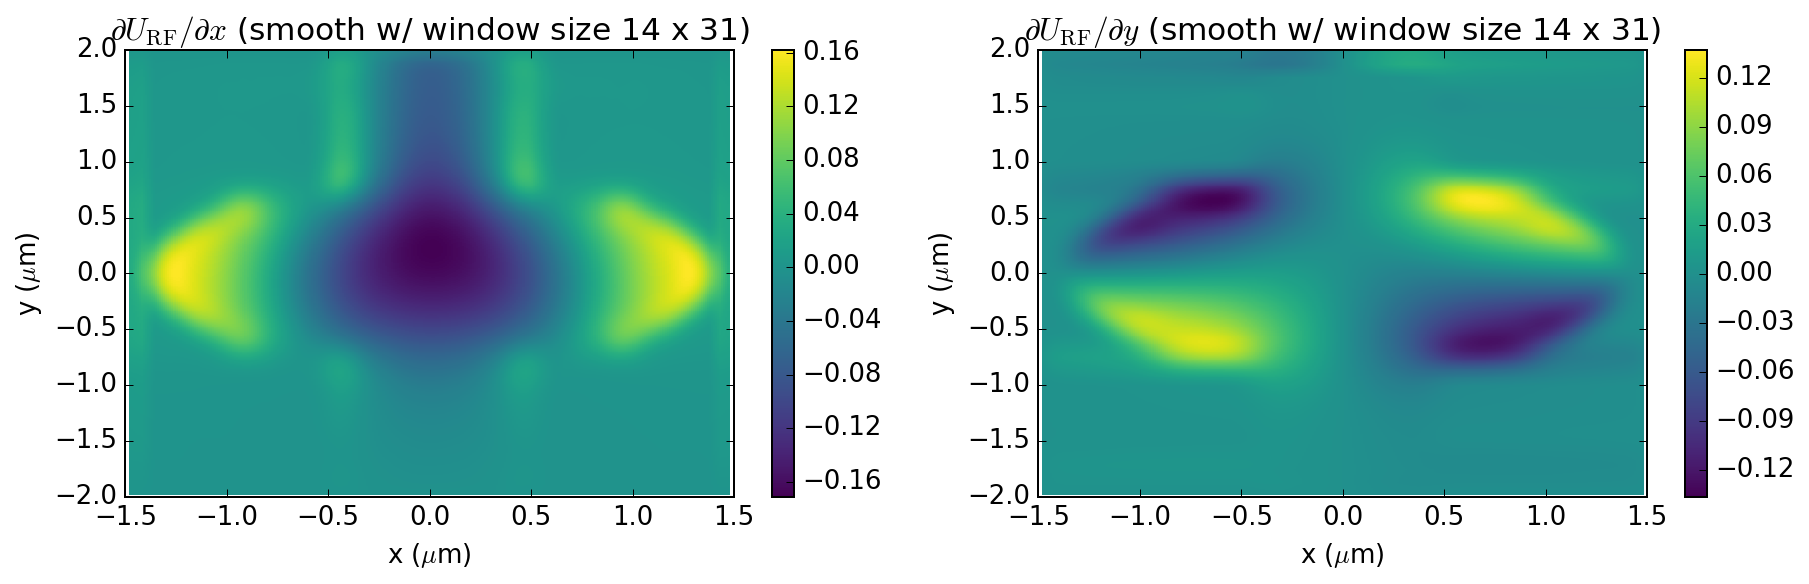

In [57]:
dx = np.diff(xinterp[0,:])[0]
dy = np.diff(yinterp[:,0])[0]

# The size in the y-direction can be set a little harsher because the potential varies more smoothly in that
# direction. If the number in parentheses is too big, smoothing may lead to loss in detail.
Nx = int(0.25 / dx)
Ny = int(0.15 / dy)

U_RF_smooth = common.moving_average_2d(Uinterp.T, window_size=(Ny,Nx))

print "The moving average window is %d x %d samples"%(Ny, Nx)

X, Y = np.meshgrid(yeval, xeval)

X_plot, Y_plot, Ex_plot = Ex(X, Y, U_RF_smooth, smoothing_window_size=(Ny,Nx))
print "The shape of the arrays after calculating the derivatives:"
print "Ex: X_plot / Y_plot / Ex"
print np.shape(X_plot), np.shape(Y_plot), np.shape(Ex_plot)

plt.figure(figsize=(15.,4.))
plt.subplot(121)
plt.title("$\partial U_\mathrm{RF}/\partial x$ (smooth w/ window size %d x %d)"%(Ny, Nx))
plt.pcolormesh(X_plot, Y_plot, Ex_plot, cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")

X_plot, Y_plot, Ey_plot = Ey(X, Y, U_RF_smooth, smoothing_window_size=(Ny,Nx))
print "Ey: X_plot / Y_plot / Ey"
print np.shape(X_plot), np.shape(Y_plot), np.shape(Ey_plot)

plt.subplot(122)
plt.title("$\partial U_\mathrm{RF}/\partial y$ (smooth w/ window size %d x %d)"%(Ny, Nx))
plt.pcolormesh(X_plot, Y_plot, Ey_plot, cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")

# Using the data to set up the Equations of Motion

## Load data into `TrapSolver`

In [58]:
reload(trap_analysis)

t = trap_analysis.TrapSolver()
t.Ex_data = -Ex_plot * 1E6
t.Ey_data = -Ey_plot * 1E6
t.curv_xx_data = - 1/2. * F_XX * 1E12
t.curv_yy_data = - 1/2. * F_YY * 1E12
t.curv_xy_data = - 1/2. * F_XY * 1E12
t.x_data = X_plot * 1E-6
t.y_data = Y_plot * 1E-6

def check_data_consistent():
    shapes = list()
    ds = dir(t)
    for d in ds:   
        if '_data' in d and d is not "use_FEM_data":
            shapes.append(np.shape(getattr(t,d)))
    return np.array(shapes)
shapes = check_data_consistent()
print shapes

[[497 297]
 [497 297]
 [497 297]
 [497 297]
 [497 297]
 [497 297]
 [497 297]]


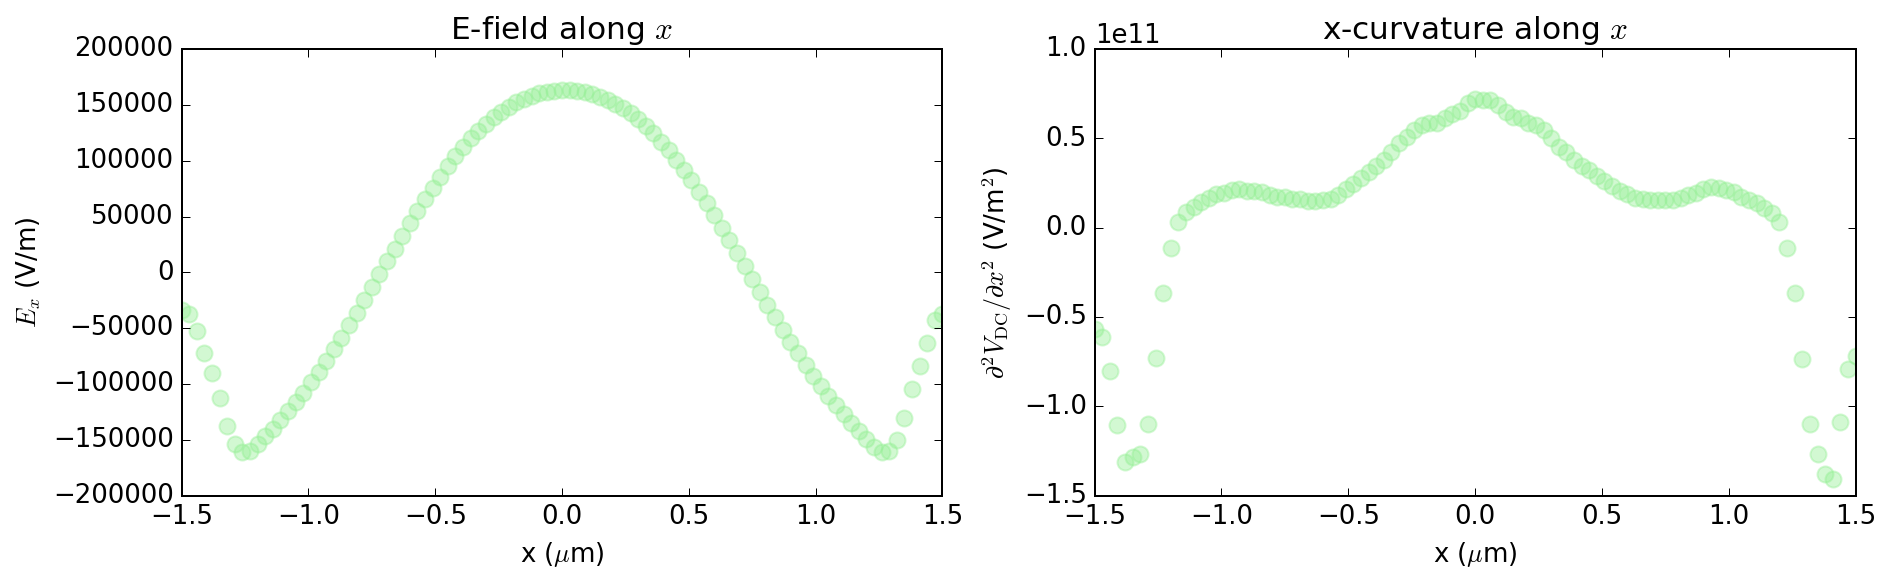

In [64]:
xtest = np.linspace(-1.5E-6, 1.5E-6, 101)
plt.figure(figsize=(15.,4.))
plt.subplot(121)
plt.plot(xtest*1E6, t.Ex(xtest, np.zeros(len(xtest))), 'o', **common.plot_opt('lightgreen'))
ax = plt.gca()
ax.set_axis_bgcolor('none')
plt.xlabel("x ($\mu$m)")
plt.ylabel("$E_x$ (V/m)")
plt.title("E-field along $x$")

plt.subplot(122)
plt.plot(xtest*1E6, 2*t.curv_xx(xtest, np.zeros(len(xtest))), 'o', **common.plot_opt('lightgreen'))
ax = plt.gca()
ax.set_axis_bgcolor('none')
plt.xlabel("x ($\mu$m)")
plt.ylabel("$\partial^2 V_\mathrm{DC}/\partial x^2$ (V/m$^2$)")
plt.title("x-curvature along $x$")


## Set up and solve EOM

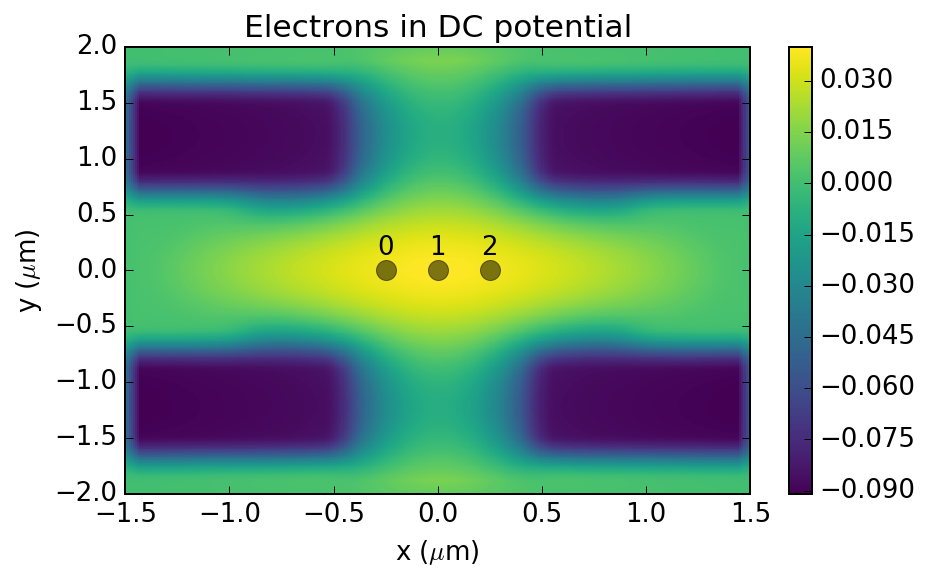

In [99]:
electron_positions = np.array([[-0.25E-6, 0.0, 0.25E-6], 
                               [0.0, 0.0, 0.0]])

plt.figure(figsize=(7.,4.))
#plt.title("$V_\mathrm{DC}$ (smooth with window size %d x %d)"%(Ny, Nx))
plt.pcolormesh(yeval, xeval, common.moving_average_2d(combined_potential.T, window_size=(Ny, Nx)), cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")
plt.title("Electrons in DC potential")

Xe, Ye = electron_positions
el = 0
for xe, ye in zip(Xe, Ye):
    plt.plot(xe*1E6, ye*1E6, 'o', alpha=0.5, color='k', ms=10)
    plt.text(xe*1E6, ye*1E6 + 0.2, "%d"%el, va='center', ha='center')
    el += 1
    
MinvK = t.setup_eom(electron_positions)
Evals, Evecs = t.solve_eom(MinvK)

In [93]:
Evals

array([  6.03674168e+22,   1.42122248e+21,   2.02622203e+21,
         1.06376243e+22,   1.91241891e+22,   3.00281229e+22,
         2.79774591e+22])

In [94]:
np.sqrt(Evals/(2*np.pi))

array([  9.80192471e+10,   1.50397667e+10,   1.79578187e+10,
         4.11464517e+10,   5.51698217e+10,   6.91312100e+10,
         6.67289360e+10])

In [100]:
print "Eigenvector %d has the largest cavity contribution with %.3e"%(np.argmax(Evecs[0,:])+1, np.max(Evecs[0,:]))

Eigenvector 2 has the largest cavity contribution with 1.066e-07


Norm for eigenvector 1 is 1.00000000
Norm for eigenvector 2 is 1.00000000
Norm for eigenvector 3 is 1.00000000
Norm for eigenvector 4 is 1.00000000
Norm for eigenvector 5 is 1.00000000
Norm for eigenvector 6 is 1.00000000
Norm for eigenvector 7 is 1.00000000


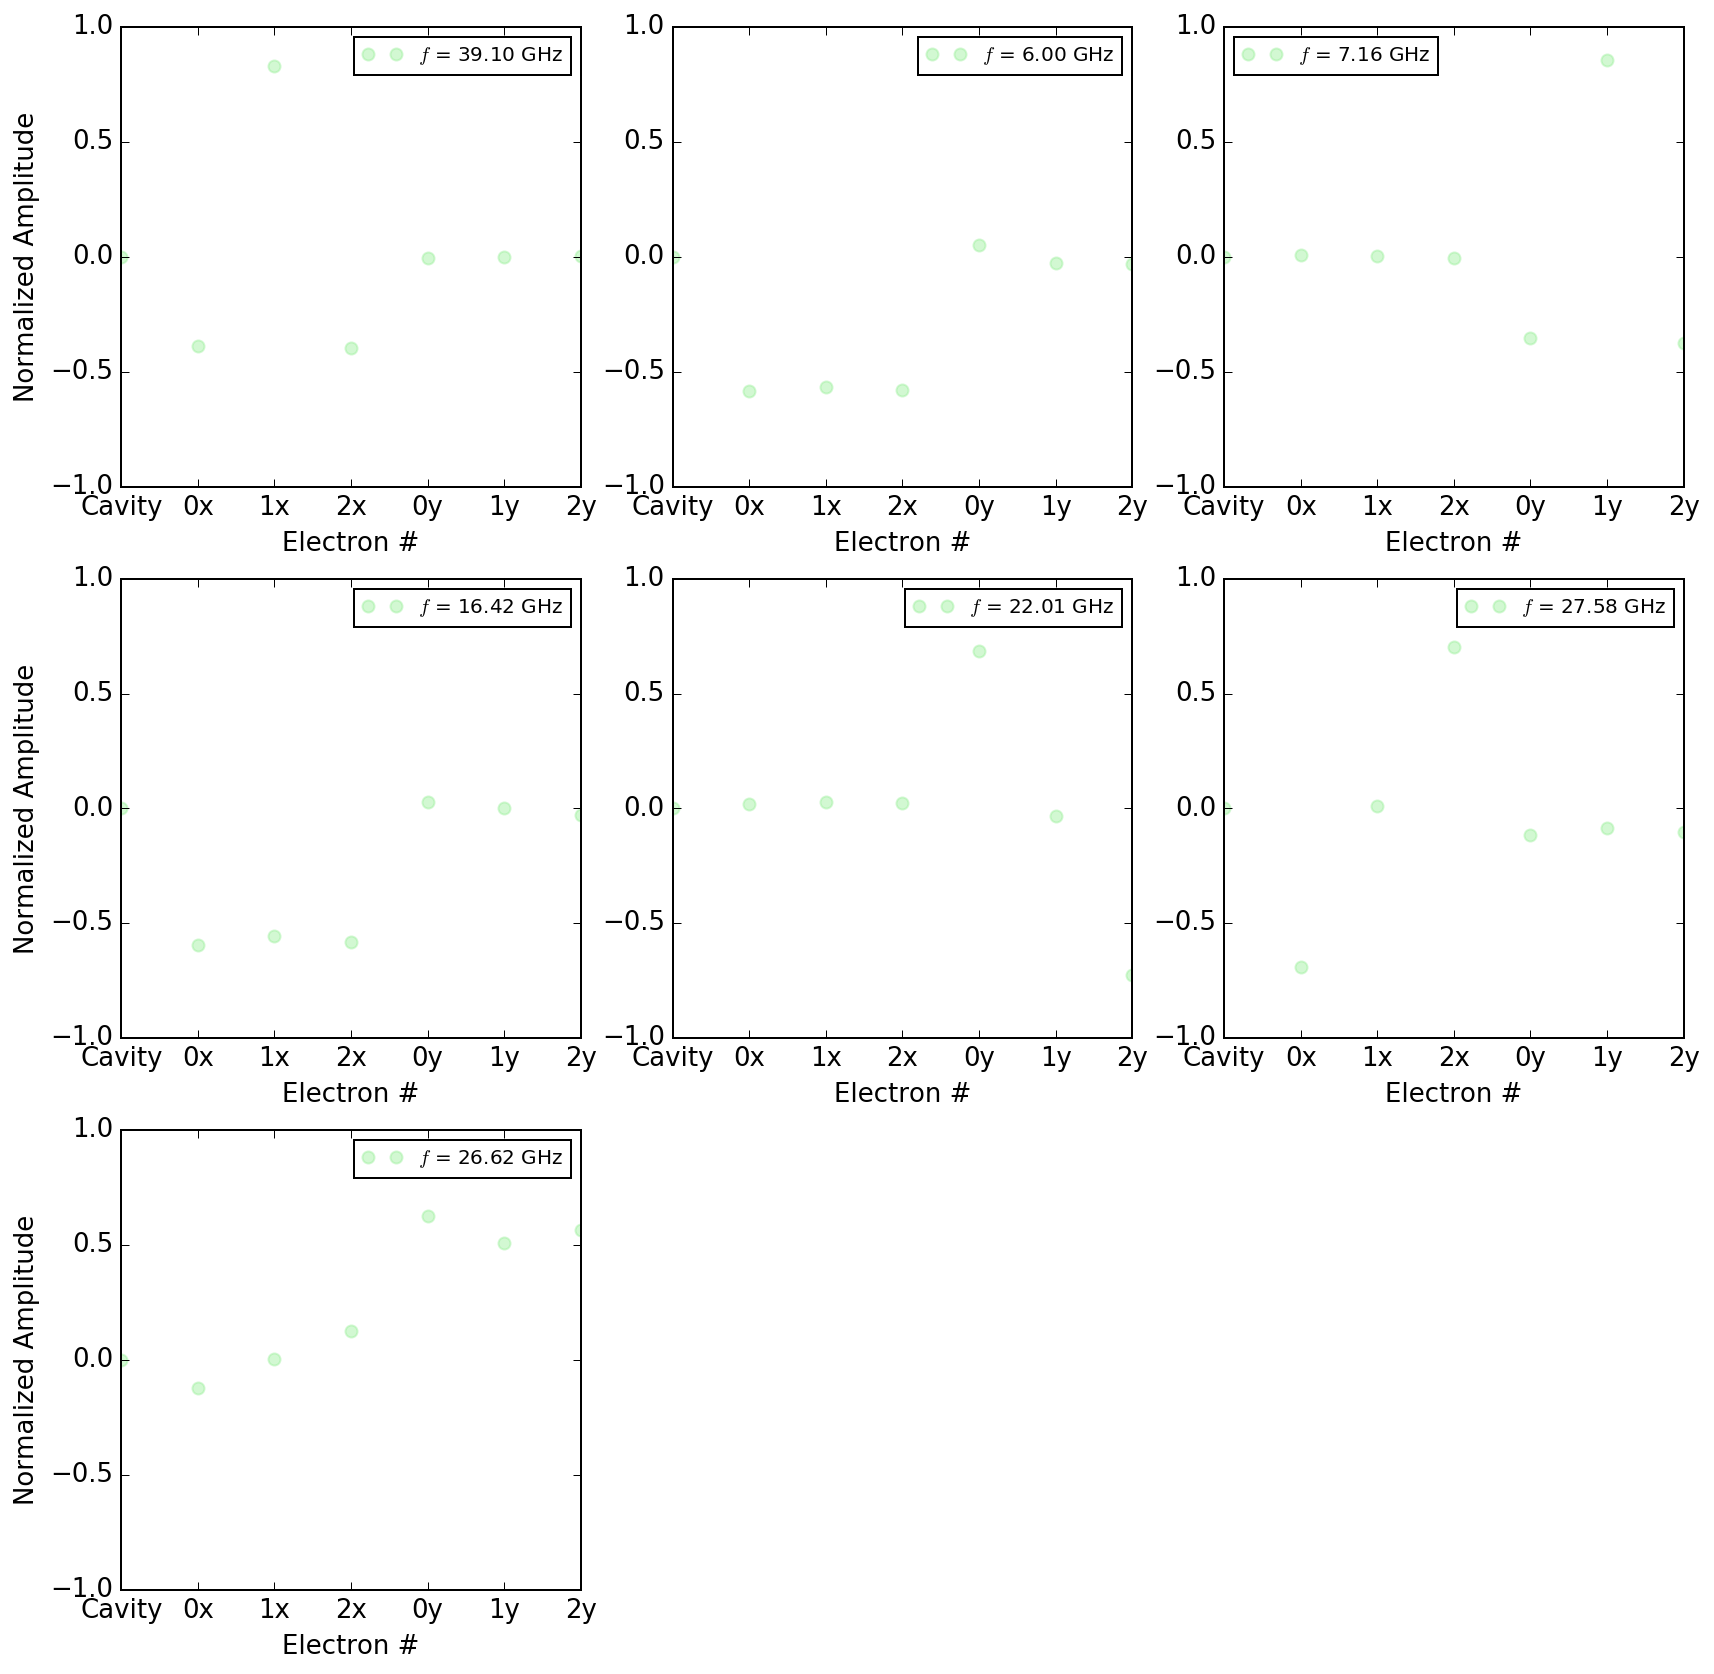

In [107]:
plt.figure(figsize=(14.,14.))

for k in range(7):
    plt.subplot("33%d"%(k+1))
    plt.plot(Evecs[:,k], 'o', label="$f$ = %.2f GHz"%(np.sqrt(Evals[k])/(2*np.pi*1E9)), 
             **common.plot_opt('lightgreen', msize=6))
    plt.xlabel("Electron #")
    ax=plt.gca()
    ax.set_axis_bgcolor('none')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0] = 'Cavity'
    num_electrons = np.shape(electron_positions)[1]
    for p in range(2*num_electrons):
        if p < num_electrons:
            labels[p+1] = '%dx'%(p%num_electrons)
        else:
            labels[p+1] = '%dy'%(p%num_electrons)
            
    ax.set_xticklabels(labels)
    ax.set_ylim(-1,1)
    
    plt.legend(loc=0, prop={'size' : 10})
    if k%3 == 0:
        ax.set_ylabel("Normalized Amplitude")
        
    print "Norm for eigenvector %d is %.8f"%(k+1, np.linalg.norm(Evecs[1:,k]))

# Visualize results